In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
from matplotlib import colormaps #type: ignore

In [2]:
cmp = 'viridis'
include_viridis = False
sv = False
dpi = 500
transparent = False
task = 'alpaca'

lora_lr=2e-5
alpha_lr = 2e-6

batch = 2
layers = 12

pth = f'/rscratch/tpang/kinshuk/RpMKin/LlaMAft/Plots/{task}'
if sv:
    print(os.getcwd())
    pth = os.path.join(os.getcwd(), pth)
    Path(pth).mkdir(parents=True, exist_ok=True)
    print(pth)

In [3]:
lora_path = (
        f"./output/{task}/lr_{lora_lr}/batch_2/lora/layers_0"
    )
lr = 2e-6
alpha_path = (
        f"./output/{task}/lr_{alpha_lr}/batch_2/alpha/layers_{layers}"
    )

In [4]:
dictionary = {
    "lora" : {'train_loss': [], 'time': []},
    "alpha" : {'train_loss': [], 'time': []},
}

dictionary = {
    "lora" : {'train_loss': [],},
    "alpha" : {'train_loss': [],},
}

for key in dictionary.keys():
    if key == "lora":
        path = lora_path
    else:
        path = alpha_path
    path = os.path.join(path, "finetune.npy")
    baseline = np.load(path, allow_pickle=True).item()
    for key2 in dictionary[key].keys():
        dictionary[key][key2].append(baseline[key2])
        dictionary[key][key2] = np.array(dictionary[key][key2])


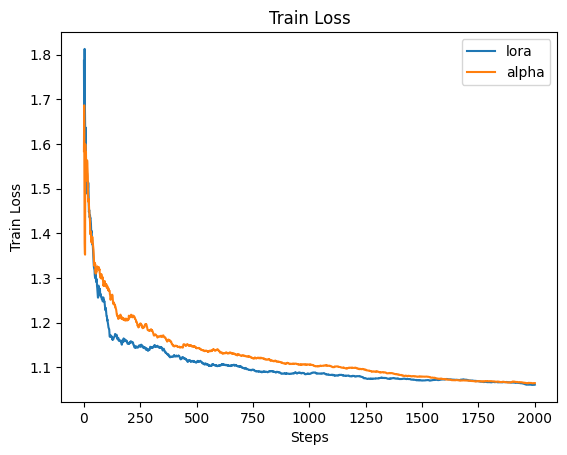

In [5]:
for key in dictionary.keys():
    plt.plot(dictionary[key]['train_loss'][0], label=key)
plt.xlabel("Steps")
plt.ylabel("Train Loss")
plt.legend()
plt.title("Train Loss")

plt.show()